# How to use the `smooth_cal` module in `hera_cal`

`hera_cal`'s `smooth_cal` module enables smoothing or "conditioning" of calibration solutions. This includes:

* Frequency smoothing by restricting the calibrations to some minimum frequency scale (or alternatively, some maximum delay).
* Time smoothing via a rolling Gaussian average of some given width.

The module also includes interfaces for loading data and calibration solutions for the file of interest, loading data and calibrations for previous and subsequent files (for time smoothing), and for writing out new calibration solutions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from hera_cal.smooth_cal import Calibration_Smoother
from hera_cal.data import DATA_PATH

## Loading data

In this demo, we'll be smoothing the calibration for antenna 36, x-polarization, for 2458099.22991. Because we're also smoothing in time, we'll load in data and calibration solutions for observations before and after.

In [2]:
antpol = (36,'x')
prev,here,subq = '22245','22991', '23737'

data = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + here + '.xx.HH.uvOR_36x_auto_only')
prev_data = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + prev + '.xx.HH.uvOR_36x_auto_only')
next_data = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + subq + '.xx.HH.uvOR_36x_auto_only')

cal = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + here + '.HH.uv.omni.calfits_36x_only')
prev_cal = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + prev + '.HH.uv.omni.calfits_36x_only')
next_cal = os.path.join(DATA_PATH, 'test_input/zen.2458099.' + subq + '.HH.uv.omni.calfits_36x_only')

These data and calibration solutions are loaded into a `Calibration_Smoother` object as follows. `data` and `cal` must be single files (or `UVData`/`UVCal` objects), but `prev_data`/`prev_cal` and `next_data`/`next_cal` can be lists of files or objects in chronological order.

In [3]:
sc = Calibration_Smoother()
sc.load_data(data, prev_data=prev_data, next_data=next_data)
sc.load_cal(cal, prev_cal=prev_cal, next_cal=next_cal)

divide by zero encountered in divide
invalid value encountered in divide


## Weighting

After loading both data and calibrations, `sc.build_weights()` is run automatically. This produces the multiplicative weights to assign to each complex gain when performing the time or frequency smoothing. Our model for the weights is:

$W_i(\nu,t) \propto \frac{\left| V_{ii}(\nu,t) \right|^2}{\left[\chi^2_{i,\text{omni}}(\nu,t)\right]}$

with all flagged channels and frequencies set to have weight of 0. Flagging comes from two sources. First, any flags on the input calibration solutions are preserved. Additionally, any flagged visibility in the data produces a flag on both antennas involved in that baseline, except if the visibility is entirely flagged because one of the two antennas involved is flagged. 

The idea here was basically to use $\chi^2$ as as a substitute for a variance, but `Omnical`'s $\chi^2$ per antenna is not normalized by any kind of noise variance, so I'm substituting in here the autocorrelations as a proxy for the noise. The whole thing is then renormalized so that the non-zero weights average to 1.0. For example, in this case, the weights look like:

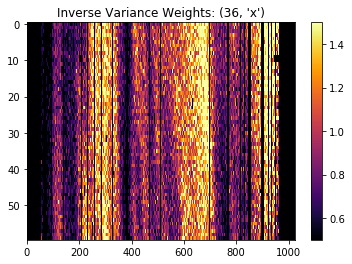

In [4]:
plt.figure()
plt.imshow(sc.wgts[antpol], cmap='inferno', aspect='auto')
plt.clim([.5, 1.5])
plt.colorbar()
plt.title('Inverse Variance Weights: ' + str(antpol));

One can forego this weighting scheme in favor of binary weights (all weights are equal unless then time and frequency are flagged) using a keyword argument to the constructor:

``` 
sc = Calibration_Smoother(binary_wgts = True)
```

## Smoothing in time

Time smoothing is performed using a weighted rolling Gaussian average. In order to ensure temporal smoothness of calibration solutions from one file to the next, it is useful to load in previous and subsequent solutions that then bookend the calibration of interest while smoothing. If they are not included (e.g. when there is not observation immediately before or after), then the calibration solution is mirrored in time to reduce edge effects. For wide smoothing kernels, this mirroring can happen several times. This process is controlled by two paramters:

* `filter_scale`: the FHMW of the Gaussian temporal smoothing kernel (given in seconds)
* `mirror_kernel_min_sigmas`: The number of stdev into the Gaussian kernel one must go before edge effects can be ignored. This sets the number of times we mirror the gains to produce smoothed solution.

The smoothed calibration solutions are always stored in the dictionary `sc.filtered_gains`. For interactive work, this can be reset with `sc.reset_filtering()` without having to reload the data and calibration solutions.

In [5]:
sc.time_filter(filter_scale=120.0, mirror_kernel_min_sigmas=5)
time_filtered = deepcopy(sc.filtered_gains[antpol])

divide by zero encountered in divide
invalid value encountered in divide


## Smoothing in frequency

Frequency smoothing is performed using a delay filter using `uvtools.dspec.high_pass_fourier_filter()` and inheriting its keyword parameters. Unlike in hera_cal.delay_filter, the default window is `'none'` rather than `'blackman-harris'`. Modes in frequency shorter than `filter_scale` are removed. In this case, the filter is at 10 MHz, which means that delay modes above 100 ns are removed from the calibration solutions. 

In [6]:
sc.freq_filter(filter_scale=10.0)

## Writing to disk

An updated calfits file is produced, using the information in the calfits file or `UVCal` object passed in to the first argument of sc.load_cal(). This provides an interface to `hera_cal.io.update_cal` with the associated keyword options.

In [7]:
outfilename = os.path.join(DATA_PATH, 'test_input/smooth_cal_test.calfits')
sc.write_smoothed_cal(outfilename, add_to_history='Written by running_smooth_cal.ipynb', clobber=True)

## Example results:

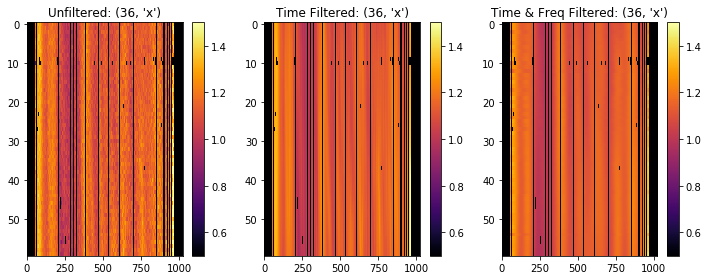

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(np.abs(sc.gains[antpol] * (sc.wgts[antpol]>0)), cmap='inferno', aspect='auto')
plt.clim([.5,1.5])
plt.colorbar()
plt.title('Unfiltered: ' + str(antpol));

plt.subplot(132)
plt.imshow(np.abs(time_filtered) * (sc.wgts[antpol]>0), cmap='inferno', aspect='auto')
plt.clim([.5,1.5])
plt.colorbar()
plt.title('Time Filtered: ' + str(antpol))

plt.subplot(133)
plt.imshow(np.abs(sc.filtered_gains[antpol]) * (sc.wgts[antpol]>0), cmap='inferno', aspect='auto')
plt.clim([.5,1.5])
plt.colorbar()
plt.title('Time & Freq Filtered: ' + str(antpol))
plt.tight_layout()

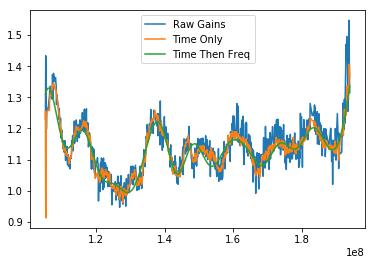

In [9]:
plt.figure()
integration = 25
wgts = sc.wgts[antpol]
gains = sc.gains[antpol]
tf_filtered = sc.filtered_gains[antpol]
freqs = sc.freqs
plt.plot(freqs[wgts[integration,:]>0], np.abs(gains[integration,:][wgts[integration,:]>0]), label='Raw Gains')
plt.plot(freqs[wgts[integration,:]>0], np.abs(time_filtered[integration,:][wgts[integration,:]>0]), label='Time Only')
plt.plot(freqs[wgts[integration,:]>0], np.abs(tf_filtered[integration,:][wgts[integration,:]>0]), label='Time Then Freq')
plt.legend();

In [10]:
try:
    os.remove(outfilename)
except (OSError):
    pass